# Final Project: Analysis of GW190521

For this assignment, you will have to conduct an analysis of the gravitational-wave signal GW190521. This analysis should be done within a Jupyter notebook, with many comments in [Markdown](https://colab.research.google.com/notebooks/markdown_guide.ipynb) desribing and **justifying** the steps taken.

- The writing should be at the level of a fellow student of the class
- Submit **both** the .ipybn file and the converted .pdf file:
  - submit the .pdf file to TurnitIn (make sure all the cells have been run).
  - and the .ipynb file by e-mail with the subject "PXT903/PX4236 Final Project"
- Describe **in details** every step of your analysis throughout the notebook.
- Any setting choice (sampling rate, window parameter, FFT length, etc...) needs to be justified, either by its own investigation or relevant citations from the literature.
- Code alone, without a detailed descriptions of what is done and why, is worth half marks at the most.

NOTE: you can use any of the notebooks covered in the class, or code available online, _provided that you justify the settings and methods used_.

In [1]:
! pip install -q gwpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
! pip install -q lalsuite pycbc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing met

In [3]:
! pip install -q emcee

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.3 MB/s eta 0:00:00


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from scipy.optimize import minimize
from IPython.display import display, clear_output
from gwosc.datasets import event_gps
from pycbc.waveform import get_td_waveform
from scipy.signal import gausspulse
from scipy.signal import correlate
from pycbc.types import timeseries
from pycbc.detector import Detector
from scipy.signal import get_window

/usr/local/lib/python3.10/dist-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


## Introduction (15 points)
Minimum 300 words.
- Write an introduction to this analysis, citing the relevant context and literature.
- Write a short summary of what is done in the notebook.

The event GW190521 was observed on the 21$^{st}$ of May 2019 at 03:02:29 UTC$^{[1]}$ and lasted for approximately 0.1 seconds. The signal was found to be of two BHs. The two BHs before the merger were found to have masses of 85M$_\odot$ and 66M$_\odot$$^{[1]}$. A luminosity distance of 5.3Gpc was estimated with two possible inclinations, reading off of figure 4$^{[1]}$ I find these two inclinations to be 0.3 and 2.7. The BHB may possibly have had an EM counterpart, it is predicted that they are in fact two AGNs$^{[2]}$. This type of observation would be monumental for GW astophysics. Unforntunately, this GW occured during observing run 2(OR2). Duing OR2 Livingston and Hanford has good sensitivty to an object at this distance but Virgo had just started up and is not very sensitive. This puts limits on how well the inclination, RA and Dec can be estimated. The discovery paper$^{[1]}$ found a remnant mass of approximately 140$_\odot$ which makes this the first observation of an IMBH.

In the following notebook the analysis of the GW signal named GW190521 is conducted. The data will by bandpassed and whitened during the analysis and suitable passes will be used as well as suitable windows for the fft.

In this analysis two models are considered, A CBC model and a Burst model. The CBC model assumes a typical GW signal with an inspiral, merger and ringdown. Whereas the Burst model assumes nothing about the underlying signal. A SEOBNRv4_opt approximant will be used to construct the CBC model and a gauspulse (sine gaussian) will be used for the Burst model. The CBC model will be constructed using data from the literature and the gauspulse will be fitted by eye to the data.

The S/N will be calculated using equations 7.58 and 7.49 of the textbook$^{[3]}$ and plotting the on source and off source S/N and comparing to the p value I will get an estimate of the false alarm rate.

Both the templates generated will be used to fit the initial parameters to the data. These parameters are: primary mass, secondary mass, RA, Dec, Inclination, phase, distance, polarisation and time of the event. The minimise function will return the best fit terms. Then a log prior function can be created with limits on values the parameters can take e.g. distance cannot be negative. This log prior will be added to the log likelihood to create a log posterior. This will produce the best guess of the parameters. These values can then be compared to the literature. To get bounds on the errors I will use the emcee sampler to sample the posterior so that corner plots can be produced

[1] - R. Abbott, T. D. Abbott, S. Abraham, et al., “Gw190521: A binary black
hole merger with a total mass of 150 M$_\odot$,” Phys. Rev. Lett., vol. 125,
p. 101 102, 10 Sep. 2020. doi: 10.1103/PhysRevLett.125.101102. [On-
line]. Available: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.125.101102. 125.101102.

[2] - M. J. Graham, K. E. S. Ford, B. McKernan, et al., “Candidate electro-
magnetic counterpart to the binary black hole merger gravitational-wave
event s190521g,” Phys. Rev. Lett., vol. 124, p. 251 102, 25 Jun. 2020. doi:
10.1103/PhysRevLett.124.251102. [Online]. Available: https://link.aps.org/doi/10.1103/PhysRevLett.124.251102.

[3] - J. D. Creighton and W. G. Anderson, Gravitational-wave physics and astronomy: An introduction to theory, experiment and data analysis. John
Wiley & Sons, 2012.

## The data and noise model (10 points)

- Download and plot the relevant gravitational-wave data for GW190521.
- Compute and plot the Power Spectrum Density.
- Compute and plot the whitened data. Use filters if necessary to best highlight where the signal is (or might be).

In [5]:
gps = event_gps('GW190521')
time_center = gps

In [6]:
# imports 16 seconds of the data either side of the time it reaches the centre of Earth (gps) for each of the 3 detectors
h1data = TimeSeries.fetch_open_data('H1', gps-16, gps+16)
l1data = TimeSeries.fetch_open_data('L1', gps-16, gps+16)
v1data = TimeSeries.fetch_open_data('V1', gps-16, gps+16)

The GW signal GW190521 was found to have had a duration of 0.1 seconds$^{[1]}$ in the detector. One could take 0.05 seconds either side of the event gps and they would have extracted the signal but they would not have enough data to distinguish GW signal from noise. Similarly, one could extract 3 hours either side of the event gps but there is a risk that this includes non stationary and non gaussian noise. Stationary and gaussian noise is one of our assumptions about the noise. Additionally, a signal of this length may also include other GW triggers. We want a signal that is somewhere between these values. I have chosen a range above here of 32 seconds. It is 2 orders of magnitude larger than duration of the GW and also a factor of $2^n$ which helps with computational speed. The plot below does not contain any abnormal peaks in amplitude. One could argue using a slightly larger time, but in this analysis I have opted not to.

[1] - R. Abbott, T. D. Abbott, S. Abraham, et al., “Gw190521: A binary black
hole merger with a total mass of 150 M$_\odot$,” Phys. Rev. Lett., vol. 125,
p. 101 102, 10 Sep. 2020. doi: 10.1103/PhysRevLett.125.101102. [On-
line]. Available: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.125.101102.
125.101102.

In [7]:
# changes the difference between two time steps (dt) to 1/2048
h1data_ds = h1data.resample(2048)
l1data_ds = l1data.resample(2048)
v1data_ds = v1data.resample(2048)

The data here has been downsampled. A value of $2^n$ is used for faster processing. Since there is no signal above the 1kHz mark, I have used 2048Hz to resample my data. The Nyquist frequency is 2048 (as shown by the 2 times upper limit of the psd which is 1024). By changing the resample rate to 2048 we double the nyquist frequency to 4096 and ensure that the data is free of aliasing.

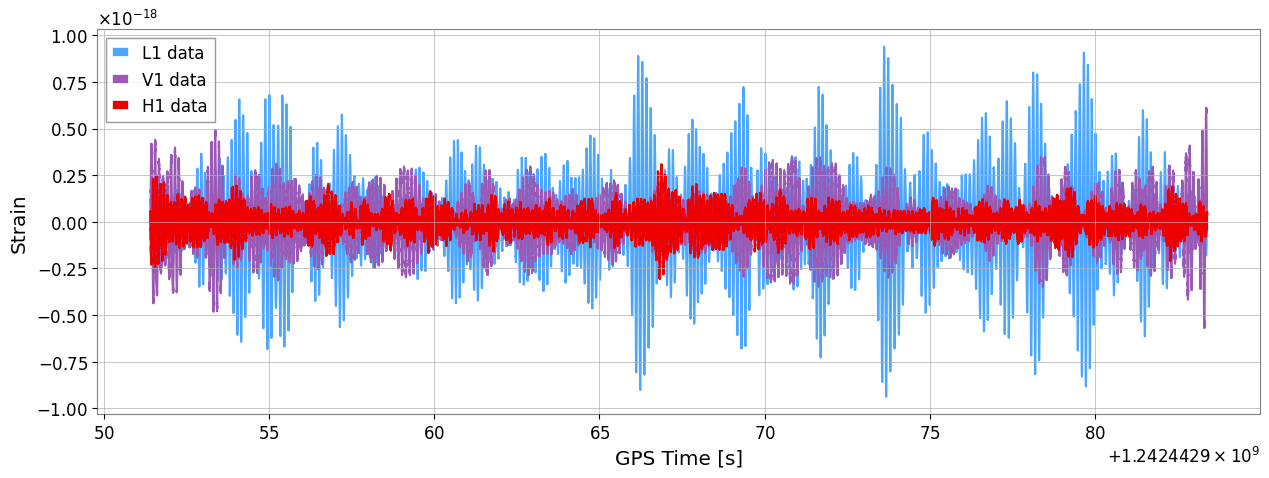

In [8]:
# plot the raw data from the detector with their respective colours
plt.figure(figsize=(15,5))
plt.plot(l1data.times, l1data, label='L1 data', color='gwpy:ligo-livingston')
plt.plot(v1data.times, v1data, label='V1 data', color='gwpy:virgo')
plt.plot(h1data.times, h1data, label='H1 data', color='gwpy:ligo-hanford')
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend()
plt.show();

In [9]:
# Calculates the PSD of the 4 seconds slices of the data overlapped every 2 seconds with the ends tapered of using the Tukey window
lpsd = l1data_ds.psd(fftlength=4, overlap=2, window=('tukey', 1./4.))
hpsd = h1data_ds.psd(fftlength=4, overlap=2, window=('tukey', 1./4.))
vpsd = v1data_ds.psd(fftlength=4, overlap=2, window=('tukey', 1./4.))

the .psd function creates a fast fourier tansform of the data and takes the square of the absolute value of the FFT and divides it by a normalisation. The downsampled data was used to create this psd. An fftlength of 4 creates the fft using 4 seconds of data. An overlap of 2 means that if the first fft occured for a time of (gps-16) to (gps-12) then the next one would occur for (gps-14) to (gps-10). An overlap of 2 ensures that all of the data outside the max and min time are sampled twice by an fft.

To stop the data beginning and ending abruptly a window has been applied. The window used is the one quarter Tukey window. This window tapers of one quarter of the data at each end of the 4 second fft leaving half of the data at peak amplitude in the centre. A simple google search will show you the shape of this taper. I have used one quarter Tukey window to ensure that the first second and the 4th second of each fft(the ones getting overlapped) are the ones having the window applied. This is so that the data is not counted twice the psd is created.

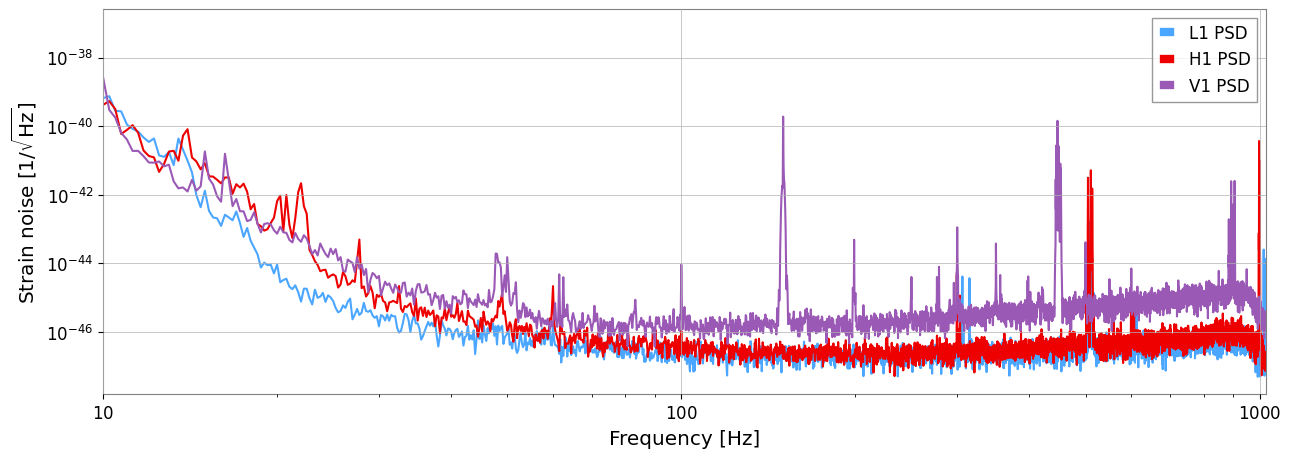

In [10]:
# plotting the psd of the each of the detectors data
plt.figure(figsize=(15,5))
plt.loglog(lpsd.frequencies, lpsd, label='L1 PSD', color='gwpy:ligo-livingston')
plt.loglog(hpsd.frequencies, hpsd, label='H1 PSD', color='gwpy:ligo-hanford')
plt.loglog(vpsd.frequencies, vpsd, label='V1 PSD', color='gwpy:virgo')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
plt.xlim(10,1024)
plt.legend();

In [11]:
# Whitens the downsampled data
l1data_wh = l1data_ds.whiten(fftlength=4, overlap=2, window=('tukey', 1./4.))
v1data_wh = v1data_ds.whiten(fftlength=4, overlap=2, window=('tukey', 1./4.))
h1data_wh = h1data_ds.whiten(fftlength=4, overlap=2, window=('tukey', 1./4.))

The .whiten function is a part of the gwpy library and it has the effect of whitening the data. To whiten the data is to normalise the power at all frequencies. Doing this makes data which has more power more obvious. SInce the function works out the power like for the psd, it also requires the same conditions discussed above.

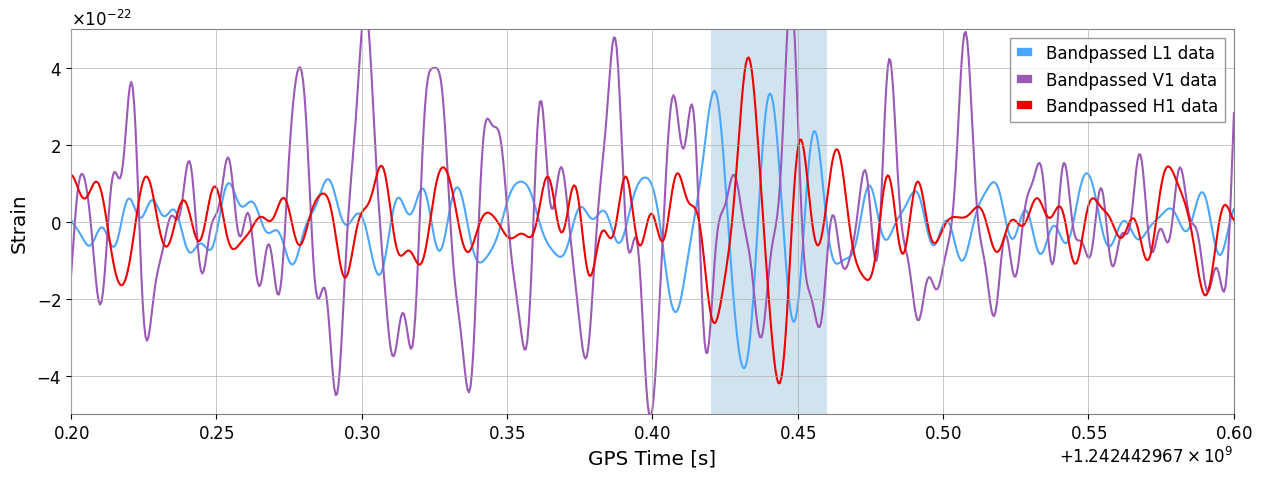

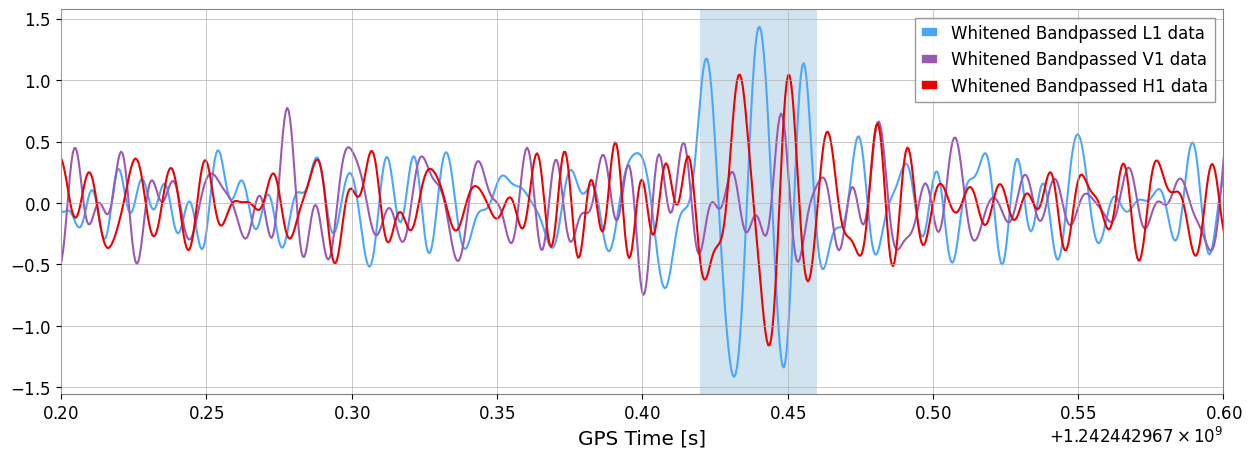

In [12]:
# The downsampled data has been highpassed at 30Hz and lowpassed at 120Hz
h1data_bp = h1data_ds.bandpass(30, 120)
l1data_bp = l1data_ds.bandpass(30, 120)
v1data_bp = v1data_ds.bandpass(30, 120)

# The whitened data has been highpassed at 30Hz and lowpassed at 120Hz
h1data_whbp = h1data_wh.bandpass(30, 120)
l1data_whbp = l1data_wh.bandpass(30, 120)
v1data_whbp = v1data_wh.bandpass(30, 120)

#plotting the bandpassed data
plt.figure(figsize=(15,5))
plt.plot(l1data_bp.times, l1data_bp, label='Bandpassed L1 data', color='gwpy:ligo-livingston')
plt.plot(v1data_bp.times, v1data_bp, label='Bandpassed V1 data', color='gwpy:virgo')
plt.plot(h1data_bp.times, h1data_bp, label='Bandpassed H1 data', color='gwpy:ligo-hanford')
plt.axvspan(gps+0.02, gps+0.06, alpha=0.2)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.xlim(gps-0.2,gps+0.2)
plt.ylim(-5e-22, 5e-22)
plt.legend();

#plotting the whitened bandpassed data
plt.figure(figsize=(15,5))
plt.plot(l1data_whbp.times, l1data_whbp, label='Whitened Bandpassed L1 data', color='gwpy:ligo-livingston')
plt.plot(v1data_whbp.times, v1data_whbp, label='Whitened Bandpassed V1 data', color='gwpy:virgo')
plt.plot(h1data_whbp.times, h1data_whbp, label='Whitened Bandpassed H1 data', color='gwpy:ligo-hanford')
plt.axvspan(gps+0.02, gps+0.06, alpha=0.2)
plt.xlabel('GPS Time [s]')
plt.xlim(gps-0.2,gps+0.2)
plt.legend();

The data above has been bandpassed. The .bandpass function defines a range for which the frequencies are kept in the data. In the above bandpass the frequency data below 30Hz and above 120Hz has been removed. The discovery paper$^{[1]}$ of GW190521 used removed the frequencies below 30Hz and above 80Hz as thats where the signal ends. I have used a highpass of 30Hz because, as can be seen on the psd, below 30Hz there is alot noise. If you lowpass the data at 80Hz you miss noise as well as higher order terms of the signal that you cannot see. Which is why I have lowpassed the data at 120Hz. I have chosen this value as it is close to the 128Hz used in a later analysis$^{[2]}$.

The amplitude of the signal around (gps+0.44) is much higher than that of the surrounding signal. Th fact that all three detectors have picked up signal which appears greater than the noise is indicitive of a GW. The shaded area signifies what I believe is the strain caused by a GW.

As you can see above even with bandpassed data you can barely make out the signal from the noise. You need to whiten the data to make the power from the GW obvious.

[1] - R. Abbott, T. D. Abbott, S. Abraham, et al., “Gw190521: A binary black
hole merger with a total mass of 150 M$_\odot$,” Phys. Rev. Lett., vol. 125,
p. 101 102, 10 Sep. 2020. doi: 10.1103/PhysRevLett.125.101102. [On-
line]. Available: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.125.101102. 125.101102.

[2] - R. Abbott, T. Abbott, S. Abraham, et al., “Properties and astrophysical
implications of the 150 M⊙ binary black hole merger gw190521,” The As-
trophysical Journal Letters, vol. 900, no. 1, p. L13, 2020. https://iopscience.iop.org/article/10.3847/2041-8213/aba493&lang=en.

## The signal model (10 points)

- Generate and plot a CBC signal which you expect to be a good match for the signal. Use the literature, and cite your sources
- Generate and plot a phenomenological model (sometimes refer to as a "Burst" model). A model whose parameters describe the shape of the waveform itself, not the source.
- Compute the overlap between those those two signals, and try to find parameters that maximises that overlap.

NOTE: remember that gravitational-wave are redshifted.

In [13]:
# masses adjusted by redshift
m1 = 85*(1+0.82)
m2 = 66*(1+0.82)

# generates the cross and plus polarisation of the strain template
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1 = m1,
                         mass2 = m2,
                         delta_t = 1./2048,
                         f_lower = 10,
                         distance = 5300,
                         inclination = 0.3)

# The burst model is created here
Burst = gausspulse(hp.sample_times, fc=62, bw=0.3)*4e-22
# The model is then converted into a pycbc timeseries
hpburst = timeseries.TimeSeries(Burst, delta_t=h1data.dt.value, epoch=hp.start_time)

hp.start_time = gps - 0.315
hc.start_time = gps - 0.315

From the discovery paper$^{[1]}$ the primary mass was found to be 85M$_\odot$ and the secondary mass was found to be 66M$_\odot$. Mass is affected by redshift and the paper finds the redshift to be 0.82$^{[1]}$. This means that the masses on the model are out by a factor of 1.82 ( 1+z correction). This makes the primary mass 154.7M$_\odot$ and the secondary mass 120.12M$_\odot$. Additionally the distance from the discovery paper was found to be 5.3Gpc$^{[1]}$ (5300Mpc).

Here I have generated a template of the plus and cross strain from the results of the discovery paper. The paper used the SEOBNRv4PHM as one of the models and I thought the SEOBNRv4_opt would be a good subsitute for this. Ideally I would use the Numerical relativity surrogate model NRSur7dq4, but it requires additional files to run that I am unable to use.

From figure 4$^{[1]}$ I read off from the degeneracy of the inclination a value of 0.3 or 2.7. I decided to use the 0.3 value for the inclination in the template.

Since I change the start time of hp in the cell I have made the burst model beforehand because the gauspulse at gps is non existent. I use gauspulse for the burst model because all it is is a sine wave that decreases in amplitude as a gaussian does. It assume nothing about the signal, which is the definition of a phenomenological model.

I have arbitrarily started my waveform at a frequency of 10Hz so as to model the inspiral. f_lower could be changed and all it would is shift the model in time, meaning that a different float is required to adjust gps in the hp start time.

[1] - R. Abbott, T. D. Abbott, S. Abraham, et al., “Gw190521: A binary black
hole merger with a total mass of 150 M$_\odot$,” Phys. Rev. Lett., vol. 125,
p. 101 102, 10 Sep. 2020. doi: 10.1103/PhysRevLett.125.101102. [On-
line]. Available: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.125.101102. 125.101102.


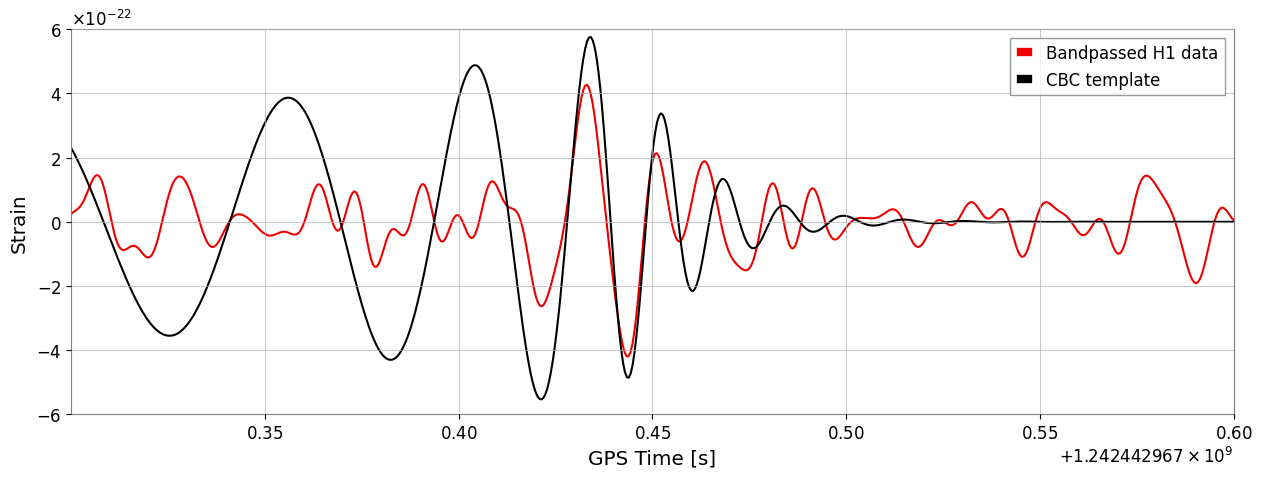

In [14]:
# plotting the CBC model against the bandpassed data
plt.figure(figsize=(15,5))
plt.plot(h1data_bp.times, h1data_bp, color='gwpy:ligo-hanford', label='Bandpassed H1 data')
plt.plot(hp.sample_times, hp, color='k', label='CBC template')
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.xlim(gps-0.1,gps+0.2)
plt.ylim(-6e-22, 6e-22)
plt.legend();

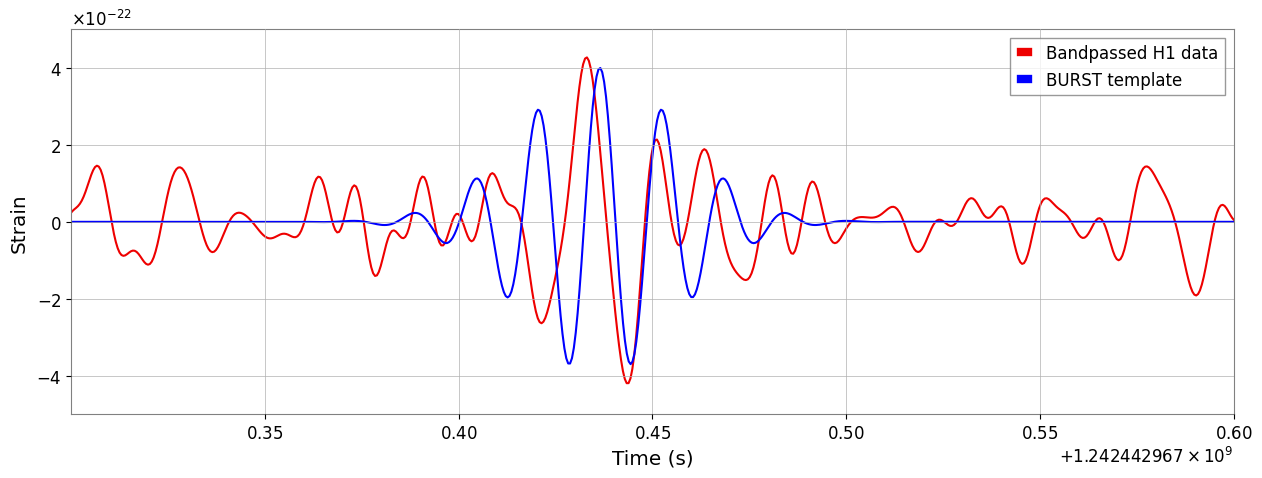

In [15]:
# plotting the phenomenological model against the data
plt.figure(figsize=(15,5))
plt.plot(h1data_bp.times, h1data_bp, color='gwpy:ligo-hanford', label='Bandpassed H1 data')
plt.plot(hp.sample_times, hpburst, color='b', label='BURST template')
plt.ylabel('Strain')
plt.xlabel('Time (s)');
plt.xlim(gps-0.1,gps+0.2)
plt.ylim(-5e-22, 5e-22)
plt.legend();

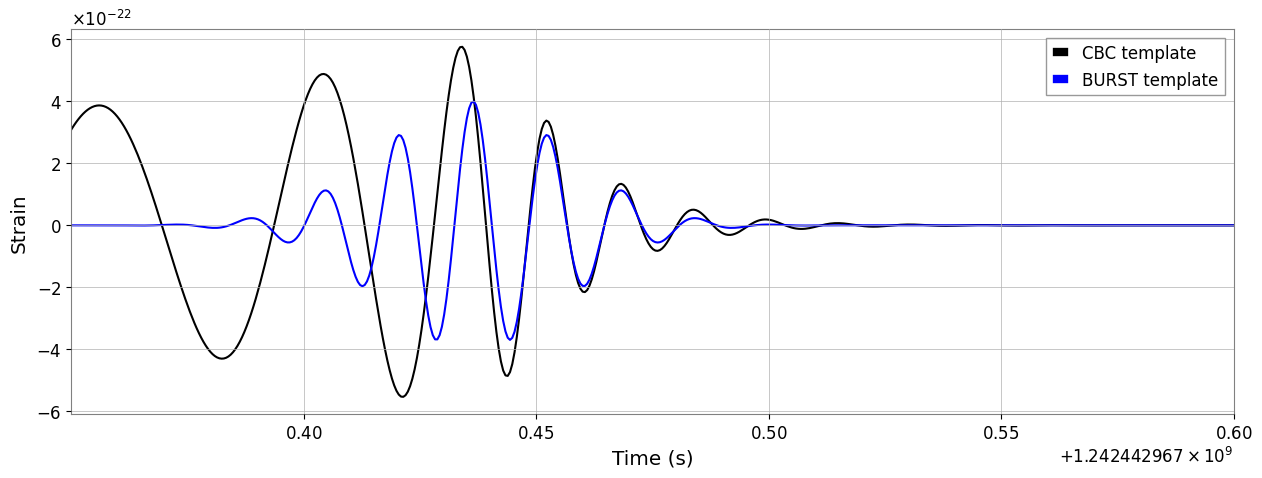

In [16]:
# The CBC and Burst model plotted over the top of one another.
plt.figure(figsize=(15,5))
plt.plot(hp.sample_times, hp, color='k', label='CBC template')
plt.plot(hp.sample_times, hpburst, color='b', label='BURST template')
plt.xlim(gps-0.05,gps+0.2)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend();

Text(0, 0.5, 'Correlation')

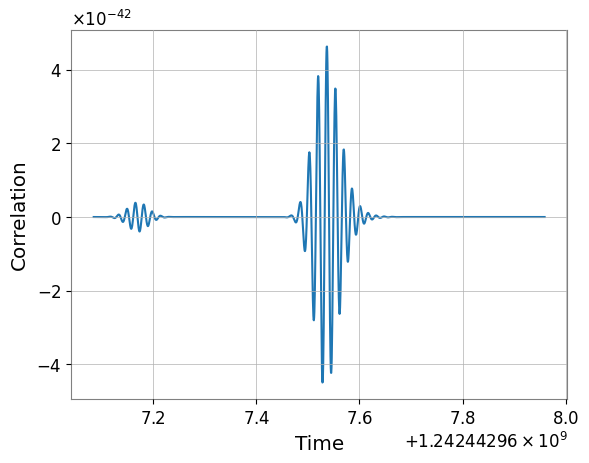

In [17]:
plt.plot(hp.sample_times, correlate(hp, hpburst, mode='same'))
plt.xlabel('Time')
plt.ylabel('Correlation')

We see a peak where we expect to during the merge event. We also see a peak when the burst model is flat and the CBC model is in the inspiral. I have adjusted the gauspulse model to attempt to maximime the amplitude of this correlation on the y axis. I have found that a band width of 0.3 and a central frequency of 62Hz maximise this correlation amplitude. I also multiply by an amplitude of 4E-22 to fit the height. I have not adjusted the parameters of the CBC model as they are meant to represent values from the literature.

## Detection (25 points)
Limiting yourself to a coincident (**not** coherent) analysis:
- Compute the SNR time series for the CBC signal model
- Compute the SNR time series for the Burst signal model
- Discuss the differences, if any.
- Estimate a bound on the False Alarm Rate of the detection.

In [18]:
# This cell for the most part is the same as in the previous question without the adjustment to start time

m1 = 85*(1+0.82)
m2 = 66*(1+0.82)

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1 = m1,
                         mass2 = m2,
                         delta_t = 1./2048,
                         f_lower = 10,
                         distance = 5300,
                         inclination = 0.3)

Burst = gausspulse(hp.sample_times, fc=62, bw=0.3)*4e-22
hpburst = timeseries.TimeSeries(Burst, delta_t=h1data_ds.dt.value, epoch=hp.start_time)

I redefine the plus and cross polarisation of the strain here as I do not want the templates start time shifted during the S/N calculation.

In [19]:
# prepends the data of hp with zeroes
hp.prepend_zeros(np.ceil((16 + hp.start_time) / hp.delta_t))
# append the data with zeros
hp.append_zeros(np.floor((16 - hp.end_time) / hp.delta_t))

#makes a timeseries of the hp data
template_hp = TimeSeries.from_pycbc(hp)
template_hp.duration # check this is 32 seconds

<Quantity 32. s>

The prepend and append are used to get the desired length of data for the template. We want a 32 second template to match our data so we use 16 seconds in the prepend and append.

In [20]:
h1data_f = h1data_ds.average_fft(window=('tukey', 1./4.)) * (h1data_ds.duration/2)
hpsd32 = hpsd.interpolate(h1data_f.df.value)

The downsampled data has had an average fft take of it using the same window as in the previous part and a normalisation has been applied. This gives the data in the frequency domain. The psd has been interpolated using the delta frequency value (The difference between two adjacent discrete values of frequency). This is to make it have the same number of points as the data so that they can be broadcast together.

In [21]:
# project the template into the frequency domain same as you did for the data
template_CBC = template_hp.average_fft(window=('tukey', 1./4.)) * (template_hp.duration/2)

# equation 7.58 of the textbook
optimal_CBC = (h1data_f * template_CBC.conjugate()) / hpsd32
opt_time_CBC = 2 * optimal_CBC.ifft() * (optimal_CBC.df*2)

# equation 7.49 of the textbook
sigmasq_CBC = 4 * np.real((template_CBC * template_CBC.conjugate() / hpsd32).sum() * template_CBC.df)
sigma_CBC = np.sqrt(np.abs(sigmasq_CBC))
# This is the timeseries of the SNR
SNR_complex_CBC = opt_time_CBC / sigma_CBC

# centre the timeseries around the peak Sin the template
peaksample_CBC = template_hp.argmax()
SNR_complex_CBC = np.roll(SNR_complex_CBC, peaksample_CBC)
SNR_CBC = abs(SNR_complex_CBC)

SNRmax_CBC = SNR_CBC.max().value
time_max_CBC = SNR_CBC.times[SNR_CBC.argmax()]
print('Maximum SNR of {} at {}.'.format(SNRmax_CBC, time_max_CBC))

Maximum SNR of 9.141845999857924 at 1242442967.4248044 s.


The S/N of each time value is calculated using equations 7.58 and 7.49 of the textbook$^{[1]}$ and dividing 7.58 by 7.49 in the time domain to get the timeseries of the S/N.

[1] - J. D. Creighton and W. G. Anderson, Gravitational-wave physics and astronomy: An introduction to theory, experiment and data analysis. John
Wiley & Sons, 2012.

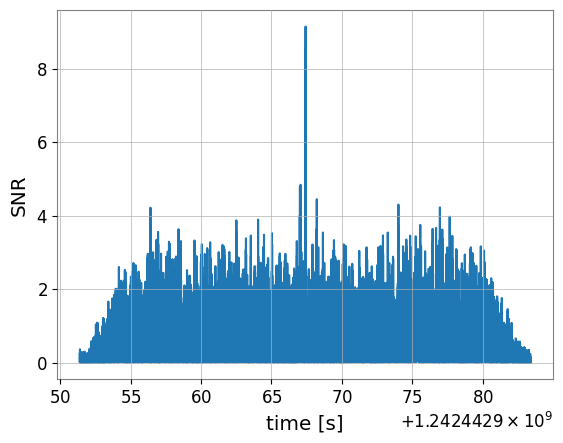

In [22]:
# plot the SNR for each discrete value of time.
plt.plot(SNR_CBC.times, SNR_CBC)
plt.xlabel('time [s]')
plt.ylabel('SNR');

In [23]:
# same as for hp
hpburst.prepend_zeros(np.ceil((16 + hpburst.start_time) / hpburst.delta_t))
hpburst.append_zeros(np.floor((16 - hpburst.end_time) / hpburst.delta_t))

template_hpburst = TimeSeries.from_pycbc(hpburst)
template_hpburst.duration

<Quantity 32. s>

In [24]:
# Same as for the CBC but with burst data
template_Burst = template_hpburst.average_fft(window=('tukey', 1./4.)) * (template_hpburst.duration/2)

optimal_Burst = (h1data_f * template_Burst.conjugate()) / hpsd32
opt_time_Burst = 2 * optimal_Burst.ifft() * (optimal_Burst.df*2)

sigmasq_Burst = 4 * np.real((template_Burst * template_Burst.conjugate() / hpsd32).sum() * template_Burst.df)
sigma_Burst = np.sqrt(np.abs(sigmasq_Burst))
SNR_complex_Burst = opt_time_Burst / sigma_Burst

peaksample_Burst = template_hpburst.argmax()
SNR_complex_Burst = np.roll(SNR_complex_Burst, peaksample_Burst)
SNR_Burst = abs(SNR_complex_Burst)

SNRmax_Burst = SNR_Burst.max().value
time_max_Burst = SNR_Burst.times[SNR_Burst.argmax()]
print('Maximum SNR of {} at {}.'.format(SNRmax_Burst, time_max_Burst))

Maximum SNR of 9.10426476200129 at 1242442967.4497068 s.


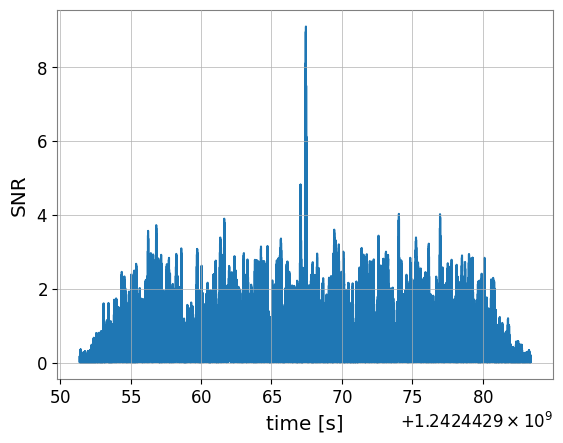

In [25]:
plt.plot(SNR_Burst.times, SNR_Burst)
plt.xlabel('time [s]')
plt.ylabel('SNR');

In [26]:
SNRmax_Burst / SNRmax_CBC # ratio of SNR values to show difference

0.9958890974692399

Both the SNR value are approximately the same value. The ratio of the two is approximately 1. I obtain a value of around 9.1 for the SNR. The reason these values are so similar is because masses this high only produce a few cycles in the ground based interfereometers. Because of this a Burst model would have the same sensitivity to the data as a CBC template would. Meaning both models are as good as one another. This explains why they yeild similar SNRs.

In [27]:
# convert the times to indices along with how large the region is in number of samples
window_size = int((1) / SNR_CBC.dt.value)
sidx = int((float(-0.25 + gps - SNR_CBC.x0.value)) / SNR_CBC.dt.value)
eidx = sidx + window_size

In [28]:
# Calculate the "on-source" peak SNR statistic value
onsource = SNR_CBC[sidx:eidx].max()

In [29]:
# calculate the background peak values
peaks = []
i = 0
while i + window_size < len(SNR_CBC):
    p = SNR_CBC[i:i + window_size].max()
    peaks.append(p)
    i += window_size

    # Skip past the onsource time
    if abs(i - sidx) < window_size:
        i += window_size * 2

peaks = np.array([p.value for p in peaks])

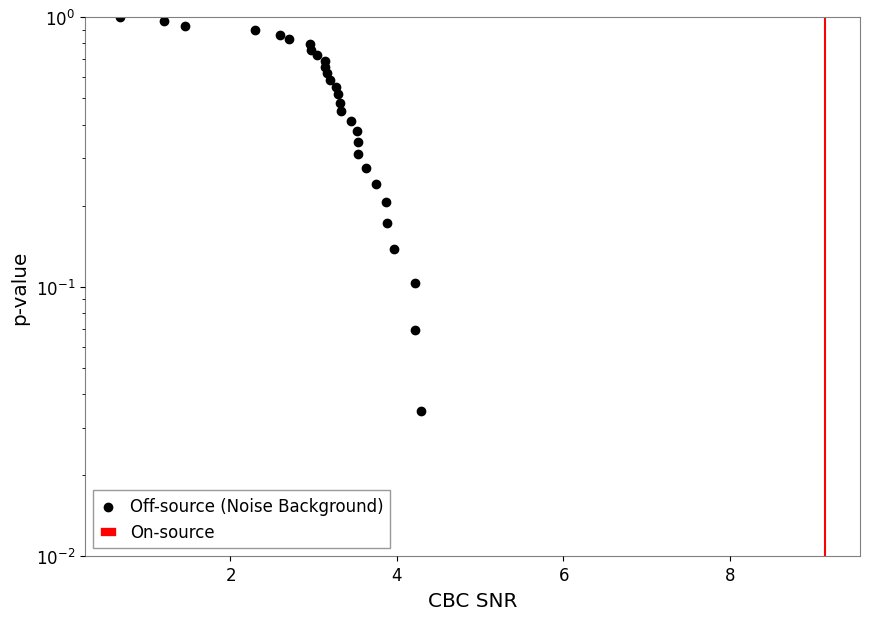

The p-value associated with the GW150914 peak is 0.0


In [30]:
# The p-value is just the number of samples observed in the background with a
# value equal or higher than the onsource divided by the number of samples.
# We can make the mapping between statistic value and p-value using our background
# samples.
pcurve = np.arange(1, len(peaks)+1)[::-1] / float(len(peaks))
peaks.sort()

pvalue = (peaks > onsource.value).sum() / float(len(peaks))

plt.figure(figsize=[10, 7])
plt.scatter(peaks, pcurve, label='Off-source (Noise Background)', color='black')

plt.axvline(onsource.value, label='On-source', color='red')
plt.axhline(pvalue, color='red')

plt.legend()
plt.yscale('log')
plt.grid()
plt.ylim(1e-2, 1e0)
plt.ylabel('p-value')
plt.xlabel('CBC SNR')

plt.show()

print("The p-value associated with the GW150914 peak is {}".format(pvalue))

In [31]:
# convert the times to indices along with how large the region is in number of samples:
window_size = int((1) / SNR_Burst.dt.value)
sidx = int((float(-0.25 + gps - SNR_Burst.x0.value)) / SNR_CBC.dt.value)
eidx = sidx + window_size

In [32]:
# Calculate the "on-source" peak SNR statistic value.
onsource = SNR_Burst[sidx:eidx].max()

In [33]:
# calculate the background peak values
peaks = []
i = 0
while i + window_size < len(SNR_Burst):
    p = SNR_Burst[i:i + window_size].max()
    peaks.append(p)
    i += window_size

    # Skip past the onsource time
    if abs(i - sidx) < window_size:
        i += window_size * 2

peaks = np.array([p.value for p in peaks])

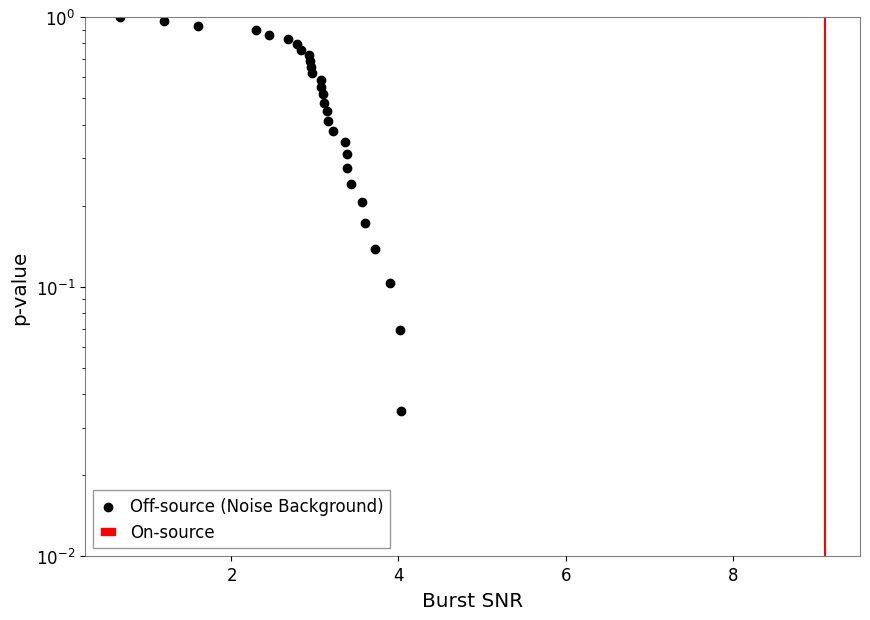

The p-value associated with the GW150914 peak is 0.0


In [34]:
# The p-value is just the number of samples observed in the background with a
# value equal or higher than the onsource divided by the number of samples.
# We can make the mapping between statistic value and p-value using our background
# samples.
pcurve = np.arange(1, len(peaks)+1)[::-1] / float(len(peaks))
peaks.sort()

pvalue = (peaks > onsource.value).sum() / float(len(peaks))

plt.figure(figsize=[10, 7])
plt.scatter(peaks, pcurve, label='Off-source (Noise Background)', color='black')

plt.axvline(onsource.value, label='On-source', color='red')
plt.axhline(pvalue, color='red')

plt.legend()
plt.yscale('log')
plt.grid()
plt.ylim(1e-2, 1e0)
plt.ylabel('p-value')
plt.xlabel('Burst SNR')

plt.show()

print("The p-value associated with the GW150914 peak is {}".format(pvalue))

Both models produce the approximately the same graph with the same p value so both will be discussed here. The p value of 0 represents the lower limit for the p value for the red line signal. The upper limit for the p value is approximately 0.25 for both models. The true p value lies in this range. We cannot tell what the true p value is because we have not collected enough noise data. The highest SNR the noise gets to is about 4.

If i had more time, I would compute the SNR for the the models with the other detectors and add the SNRs in quadrature to reach a higher overall noise SNR so that I can better probe p-value space.

Since only 32 seconds of time has been looked at here and no higher SNR noise has been found in the data, we can put an upper limit on the false alarm rate. We know that at most it is 1 in every 32 seconds. It is extremely likely that this false alarm rate is much lower than this.

Additionally, if I had more time I would use more data perhaps 1024 seconds or even 2048 seconds to calculate the SNR so that I could put a lower upper limit on the SNR. By doing this I would likely see higher SNR noise as well

## Parameter Estimation (25 points)
Moving to a **coherent** analysis:
- Using the CBC model, build a likelihood, prior and posterior function for the network of gravitational-wave detectors.
- Maximise that function and plot the relevant quantities.
- Interface that posterior function with a sampling algorithm (you are free to select any ready-made algorithm).
- Perform the sampling, and plot the results.
- Redo the steps above with the Burst model.
- Compare the results and discuss.

In [35]:
# defining arrays of the detectors used and their colours
ifos = ['H1', 'L1', 'V1']
colours = ['gwpy:ligo-hanford', 'gwpy:ligo-livingston','gwpy:virgo']

In [36]:
# As we are now doing a coherent analysis I think using dictionary form is better.
det = {}
for ifo in ifos:
    det[ifo] = Detector(ifo)

In [37]:
# create dictionary of the resampled 32 second data at each detector
data = {}
data['H1'] = h1data_ds
data['L1'] = l1data_ds
data['V1'] = v1data_ds

# create dictionary of the resampled 32 second whitened data at each detector
white_data = {}
white_data['H1'] = h1data_whbp
white_data['L1'] = l1data_whbp
white_data['V1'] = v1data_whbp

In [38]:
# create dictionary of the psd for which 32 seconds were used to make it
psd={}
psd['H1'] = hpsd
psd['L1'] = lpsd
psd['V1'] = vpsd

In [39]:
# cropping the data to 4 seconds
for ifo in ifos:
    data[ifo] = data[ifo].crop(time_center-2, time_center+2)

We crop the data to 4 seconds because if you use 32 seconds the minimise functions tries to fit the noise and the amplitudes skyrocket

In [40]:
# CBC template being generated
def gen_template(param,
                 delta_t = data['H1'].dt.value, # Assuming all IFOs have the same dt !
                 duration = data['H1'].duration.value, # Assuming all IFOs have the same duration !
                 start_time = data['H1'].x0.value,# Assuming all IFOs have the same start time !
                 f_lower=10.):

    m1, m2, distance, time, phase, right_ascension, declination, inclination, polarization = param

    hp, hc = get_td_waveform(approximant = "SEOBNRv4_opt",
                             mass1 = m1,
                             mass2 = m2,
                             distance = distance,
                             inclination = inclination,
                             coa_phase = phase,
                             delta_t = delta_t,
                             f_lower = f_lower)

    # Resize the signal buffer
    hp.resize(int(duration/delta_t))
    hc.resize(int(duration/delta_t))

    ht = {}
    template = {}
    # compute the detectors responses and shift to the requested time
    for ifo in ifos:
        # calculate the antenna pattern for the source of the GW
        fp, fc = det[ifo].antenna_pattern(right_ascension, declination, polarization, time)
        ht[ifo] = fp * hp.copy() + fc * hc.copy()

        time_delay = det[ifo].time_delay_from_earth_center(right_ascension, declination, time)

        ht[ifo] = ht[ifo].cyclic_time_shift(ht[ifo].start_time + time - start_time + time_delay)
        ht[ifo].start_time = start_time

        template[ifo] = TimeSeries.from_pycbc(ht[ifo])

    return template

The basis of this template comes from the matrix equation in week 10s lectures.

$$\textbf{d=Fh+n}$$

where **F** contains the F$_\times$ and F$_+$, h contains the the template plus and cross polarisation and the noise is added to the end, this is all equal to the detected measurement, d. Note the F$_\times$ and F$_+$ must be normalised using whitened data. Which is what we do in the minimise function.

h(t) in the template above is the matrix multiplication of Fh in the above equation. We assume the noise is not correlated between detectors and so n in the equation is not required.

We then calculate the time delay for each detector based on how the sky location and when the GW reached the centre of Earth

In [41]:
# Since its easier to work in the frequency domain when doing the inner product we do the fft in advance
sf={}
for ifo in ifos:
    sf[ifo] = data[ifo].average_fft(window = ('tukey', 1./4.)) * data[ifo].duration.value/2

In [72]:
def loglikelihood(param, sf = sf, f_lower = 10.0):

    logl = 0.0
    template = gen_template(param, delta_t = data['H1'].dt.value, f_lower = f_lower)

    for ifo in ifos:
        # zero out the frequencies below f_lower
        sf_hp = sf[ifo].crop(start = f_lower)
        psd_hp = psd[ifo].crop(start = f_lower)

        hf = template[ifo].average_fft(window = ('tukey', 1./4.)) * template[ifo].duration.value/2
        hf_hp = hf.crop(start = f_lower)

        # This here is the inner product between h and h as well as h and s
        h_dot_h = 4 * np.real((hf_hp * hf_hp.conjugate() / psd_hp).sum() * hf_hp.df)
        h_dot_s = 4 * np.real((sf_hp * hf_hp.conjugate() / psd_hp).sum() * sf_hp.df)

        logl += h_dot_s - h_dot_h/2

    return logl.value

We calculate the Likelihood here using the equation below

$$L=d^TFh+(Fh)^Td-(Fh)^TFh$$

LHS is h_dot_s and RHS is h_dot_h

In [43]:
m1 = 85*(1+0.82)
m2 = 66*(1+0.82)
d = 5300
t = 1242442967.4 + 0.03# gps
phase = 0
RA = 3.36
Dec = -0.6078
i = 0.3
p = 0 #polarisation

param0 = [m1, m2, d, t, phase, RA, Dec, i, p]

Here are my initial parameters for my logliklihood function. m1, m2, d and i have been previously discussed. The initial values used for RA and Dec come from a potential EM counterpart$^{[1]}$. The below values were converted from h:m:s to radians. No concrete information could be found for the phase and polarisation so they have been fixed to zero and will be minimised in the following steps. I have adjusted my time t by 0.03 seconds above the gps time to push my template over the signal to allow for an quicker parameter estimation.

RA: 12h 49m 42.3s -> 3.36 radians

Dec: -34° 49' 29" -> -0.6078 radians

[1] - M. J. Graham, K. E. S. Ford, B. McKernan, et al., “Candidate electro-
magnetic counterpart to the binary black hole merger gravitational-wave
event s190521g,” Phys. Rev. Lett., vol. 124, p. 251 102, 25 Jun. 2020. doi:
10.1103/PhysRevLett.124.251102. [Online]. Available: https://link.aps.org/doi/10.1103/PhysRevLett.124.251102.

In [44]:
# Uses the gen_template function to make the template for my parameters
template0 = gen_template(param0)

-8.977827728887421


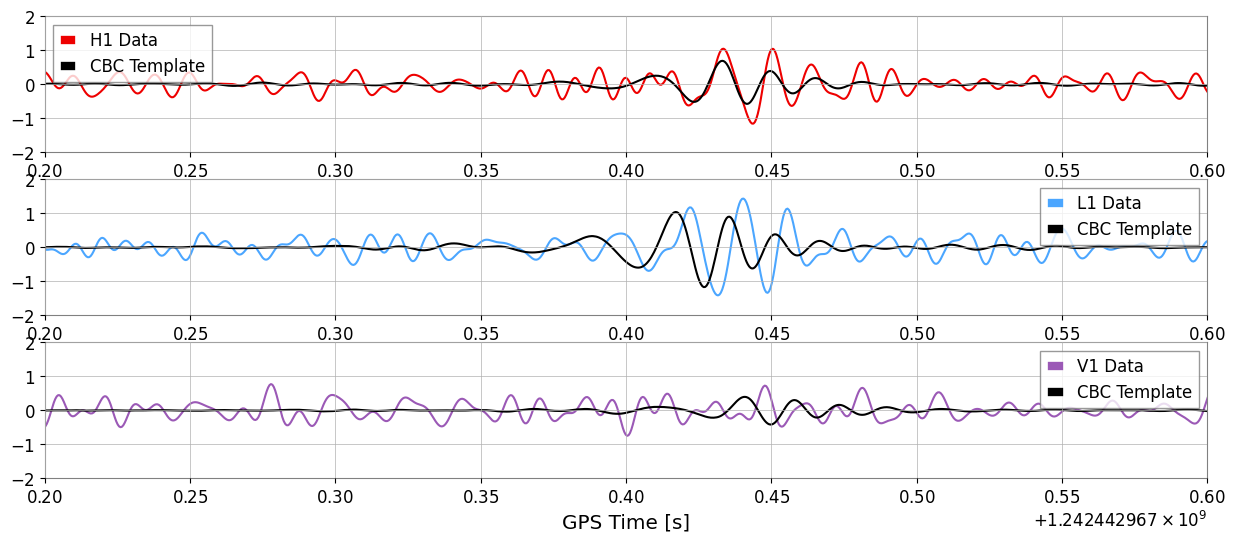

In [45]:
# This plots the initial first guess at the likelihood
fig, axs = plt.subplots(3, 1, figsize=[15, 6])

for ax, ifo, colour in zip(axs, ifos, colours):
    white_template = template0[ifo].whiten(asd = np.sqrt(psd[ifo]), highpass = 20.)

    ax.plot(white_data[ifo].times, white_data[ifo], color = colour, label = f"{ifo} Data")
    ax.plot(white_template.times, white_template, color = 'k', label = "CBC Template")
    ax.set_xlabel('GPS Time [s]')

    ax.set_xlim(gps-0.2, gps+0.2)
    ax.set_ylim(-2, 2)
    ax.legend();
print(loglikelihood(param0))

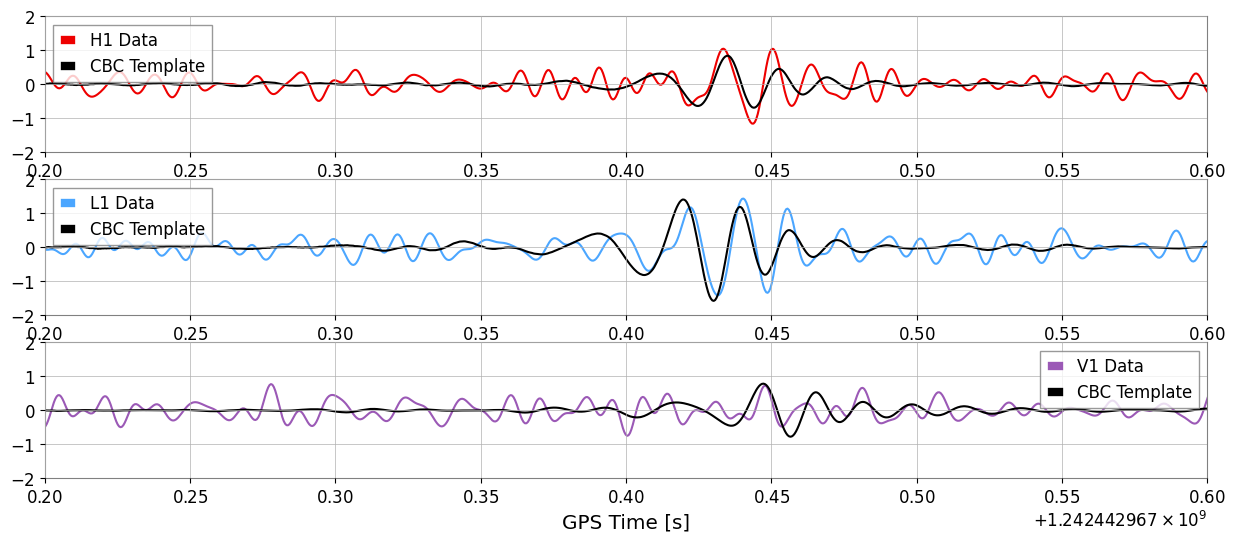

Steps	log(likelihood)
9	92.982


In [46]:
fig, axs = plt.subplots(3, 1, figsize=[15, 6])
Neval = 1

lines = {}
for ax, ifo, colour in zip(axs, ifos, colours):
    hite_template = template0[ifo].whiten(asd = np.sqrt(psd[ifo]), highpass = 20.)

    ax.plot(white_data[ifo].times, white_data[ifo], color = colour, label = f"{ifo} Data")
    lines[ifo], = ax.plot(white_template.times, white_template, color = 'k', label = "CBC Template")

    ax.set_xlabel('GPS Time [s]')
    ax.set_xlim(gps-0.2, gps+0.2)
    ax.set_ylim(-2, 2)
    ax.legend()

# This function decides whether or not to continue the minimisation
def callback(param_i):
    global Neval
    global line
    global fig

    template = gen_template(param_i)
    for ifo in ifos:
        white_template = template[ifo].whiten(asd = np.sqrt(psd[ifo]), highpass = 20.)
        lines[ifo].set_ydata(white_template)

    clear_output(wait = True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, loglikelihood(param_i)))

    Neval += 1
# calculates the residuals of the minimisation
res = minimize(lambda param: -loglikelihood(param), param0, callback = callback, method = 'powell')
plt.close()

The templates above have been highpassed at 20Hz because if they are not then there is spectral leakage with the data that starts at 10Hz as well as the tenplate begins to fit to the noise causing the amplitude to skyrocket.

We have quite noisy data and so when minimising, scipy.optimize has two good options, Nelder-Mead or Powell. I have used the Powell method here to minimise the logliklihood but you could use the Nelder-Mead method.

We get a logliklihood here of around 100, this is consistent with the SNR calculated in the previous part which was 9.1 (This is because the square root of the loglikelihood is the SNR).

As you can see from the loglikelihood above, it is very difficult to tell the difference between noise and GW signal in the Virgo data. This is due to its poor sensitivity at the time of this observation.

In [47]:
best_fit = res.x
print(best_fit)

[ 1.52541346e+02  1.45148813e+02  3.58414567e+03  1.24244297e+09
  9.14911866e-03  3.12863459e+00 -5.96118680e-01  2.20138720e-08
  5.73098220e-02]


Here are our best_fit parameters. I can already see that the masses are looking good but distance is a little low. I will now construct a prior function.

In [48]:
def logprior(param):
    logp = 0

    m1, m2, distance, time, phase, ra, dec, inclination, polarization = param

    for angle in [ra, phase, polarization]:
        if angle < 0 or angle > 2*np.pi:
            return -np.inf
    if distance < 0:
        return -np.inf
    if m1 < 5:
        return -np.inf
    if m2 < 5:
        return -np.inf
    if inclination < 0 or inclination > np.pi:
        return -np.inf
    if dec < -np.pi/2 or dec > np.pi/2:
        return -np.inf

    logp += np.log(np.cos(dec))
    logp += 2*np.log(distance)
    logp += np.log(np.sin(inclination))
    logp += np.log(m1)
    logp += np.log(m2)
    return logp

Here I chose to not use a uniform prior and will make assumptions like distance cannot be negative, declination must remain within -$\pi$/2 and $\pi$/2, the inclination must not be negative and the RA, phase and polarisation must all be within 0 and 2$\pi$. I was having some issues with my posterior tending towards -ve masses when I only restricted my masses to greater than zero. Therefore, I have opted to use the upper mass gap limit of 5M$_\odot$ as the restriction on both my masses. This is because the paper defines this CBC as a BHB event and as far as I know there have been no significant detections of a BH less than 5M$_\odot$.

The log values of the input param values are then added together to make a total loglikelihood.

Since I have added changes to what I will sample the mass for I need to add it to the log posterior so I have included logp += np.log(m1,2) to the code to take into account that I am only sampling a little less than half of parameter space for the masses now.

In [49]:
def logposterior(param):
    logpost = logprior(param)
    if np.isfinite(logpost):
        logpost += loglikelihood(param)
    return logpost

Here the the logposterior is defined as the addition between the logprior and loglikelihood (by log rules and Bayes theorem).

In [50]:
logposterior(param0)

16.586711153305927

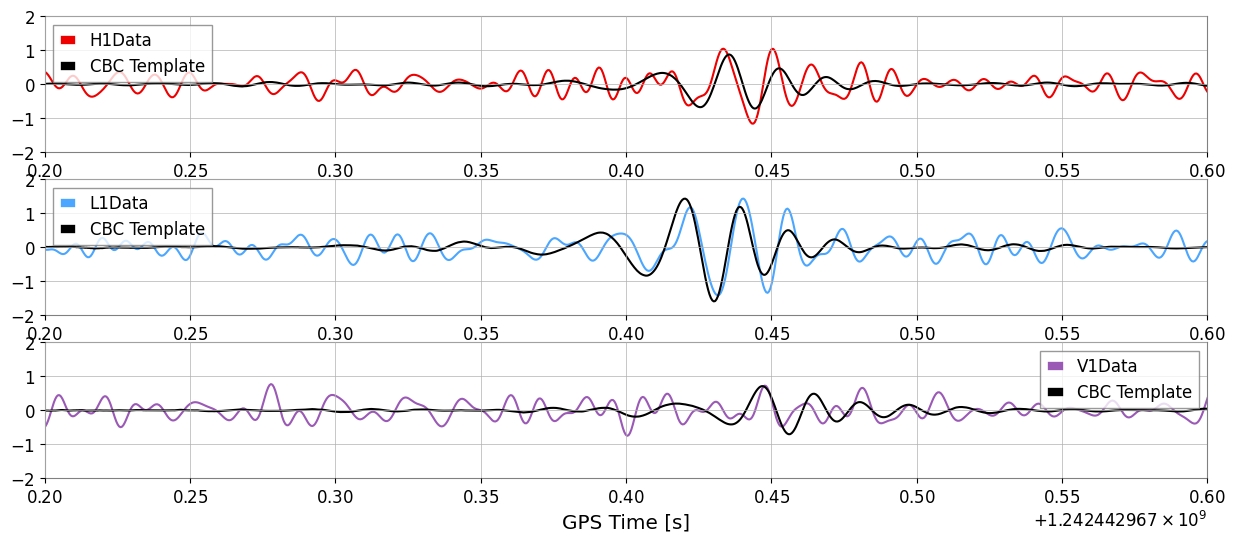

Steps	log(posterior)
6	118.882


In [51]:
fig, axs = plt.subplots(3, 1, figsize=[15, 6])
Neval = 1

lines = {}
for ax, ifo, colour in zip(axs, ifos, colours):
    hite_template = template0[ifo].whiten(asd = np.sqrt(psd[ifo]), highpass = 20.)

    ax.plot(white_data[ifo].times, white_data[ifo], color = colour, label = f"{ifo}Data")
    lines[ifo], = ax.plot(white_template.times, white_template, color = 'k', label = "CBC Template")

    ax.set_xlabel('GPS Time [s]')
    ax.set_xlim(gps-0.2, gps+0.2)
    ax.set_ylim(-2, 2)
    ax.legend()

def callback(param_i):
    global Neval
    global line
    global fig

    template = gen_template(param_i)
    for ifo in ifos:
        white_template = template[ifo].whiten(asd = np.sqrt(psd[ifo]), highpass = 20.)
        lines[ifo].set_ydata(white_template)

    clear_output(wait = True)
    display(fig)
    print("Steps\tlog(posterior)")
    print('{}\t{:.3f}'.format(Neval, logposterior(param_i)))

    Neval += 1

res = minimize(lambda param: -logposterior(param), param0, callback = callback, method = 'powell')
plt.close()

The above minimisation is identical to the loglikelihood except it minimises the logposterior function.

In [52]:
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -118.88232059410593
       x: [ 1.550e+02  1.345e+02  3.286e+03  1.242e+09  1.043e-02
            3.184e+00 -5.880e-01  5.164e-01  3.691e-03]
     nit: 6
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-2.574e-02 -2.723e-03 ...  1.047e-01  9.429e-04]]
    nfev: 1143

In [53]:
best_guess = res.x
print(best_guess)

[ 1.55043862e+02  1.34474863e+02  3.28591837e+03  1.24244297e+09
  1.04322147e-02  3.18423942e+00 -5.88035549e-01  5.16392959e-01
  3.69077084e-03]


In [54]:
print("The best guess for m1 is {:.3f}".format(best_guess[0]))
print("The best guess for m2 is {:.3f}".format(best_guess[1]))
print("The best guess for the distance is {:.3f}".format(best_guess[2]))
print("The best guess for the inspiral start time is {:.3f}".format(best_guess[3]))
print("The best guess for the phase is {:.3f}".format(best_guess[4]))
print("The best guess for the right ascension is {:.3f}".format(best_guess[5]))
print("The best guess for the declination is {:.3f}".format(best_guess[6]))
print("The best guess for the inclination is {:.3f}".format(best_guess[7]))
print("The best guess for the polarisation is {:.3f}".format(best_guess[8]))

The best guess for m1 is 155.044
The best guess for m2 is 134.475
The best guess for the distance is 3285.918
The best guess for the inspiral start time is 1242442967.432
The best guess for the phase is 0.010
The best guess for the right ascension is 3.184
The best guess for the declination is -0.588
The best guess for the inclination is 0.516
The best guess for the polarisation is 0.004


I know the order in which these were run is not linear but it will work if run normally.

Text(0, 0.5, 'log(L)')

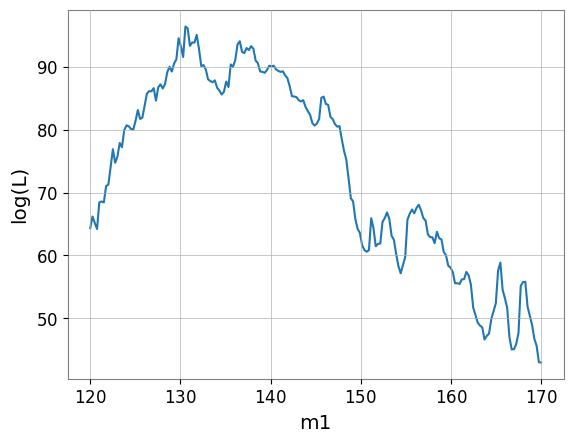

In [75]:
masses = np.linspace(120, 170, num=200)
logl_mass = []

for mass1 in masses:
    param_test = best_guess
    param_test[0] = mass1
    logl_mass.append(loglikelihood(param_test))

plt.plot(masses, logl_mass)
plt.xlabel('m1')
plt.ylabel('log(L)')

Text(0, 0.5, 'log(L)')

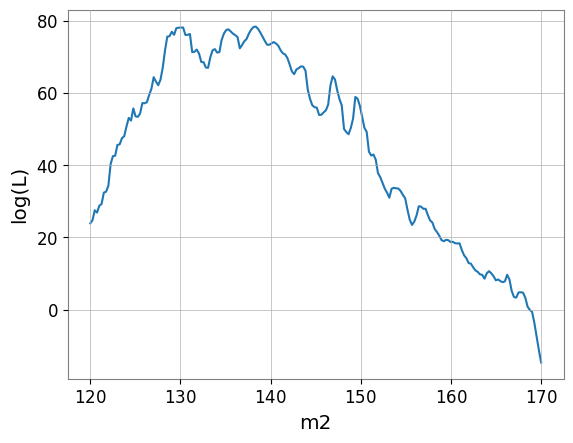

In [76]:
masses = np.linspace(120, 170, num=200)
logl_mass = []

for mass2 in masses:
    param_test = best_guess
    param_test[1] = mass2
    logl_mass.append(loglikelihood(param_test))

plt.plot(masses, logl_mass)
plt.xlabel('m2')
plt.ylabel('log(L)')

Text(0, 0.5, 'log(L)')

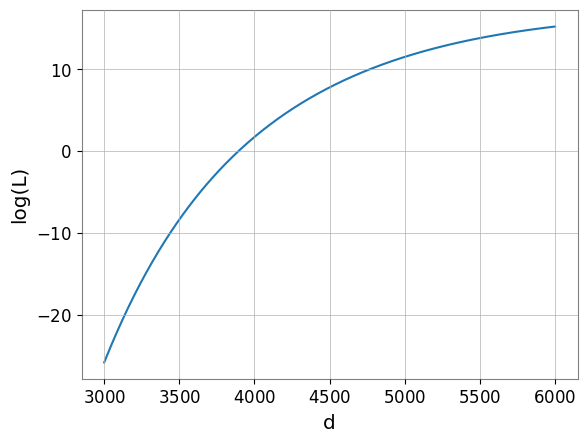

In [77]:
distance = np.linspace(3000, 6000, num=300)
logl_d = []

for d in distance:
    param_test = best_guess
    param_test[2] = d
    logl_d.append(loglikelihood(param_test))

plt.plot(distance, logl_d)
plt.xlabel('d')
plt.ylabel('log(L)')

You can clearly see a loglikelihood peak in the m1 distribution, however, m1 has been trapped on the RHS of that dip. Similarly m2 was caught by a dip in the loglikelihood which may be why it never converged to 120.12M$_\odot$. This was because the loglikelihood of getting 120.12M$_\odot$ was the same as the result of 134.475M$_\odot$ The loglikelihood of the distance just increases constantly, probably to 9000, I am unsure as to why.

In [56]:
def logposterior(theta, data, sigma, x):
    """
    The natural logarithm of the joint posterior.

    Args:
        theta (tuple): a sample containing individual parameter values
        data (list): the set of data/observations
        sigma (float): the standard deviation of the data points
        x (list): the abscissa values at which the data/model is defined
    """

    lp = logprior(theta) # get the prior

    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf

    # return the likeihood times the prior (log likelihood plus the log prior)
    return lp + loglikelihood(theta, data, sigma, x)

def loglikelihood(theta, data, sigma, x):
    """
    The natural logarithm of the joint Gaussian likelihood.

    Args:
        theta (tuple): a sample containing individual parameter values
        data (list): the set of data/observations
        sigma (float): the standard deviation of the data points
        x (list): the abscissa values at which the data/model is defined

    Note:
        We do not include the normalisation constants (as discussed above).
    """

    # unpack the model parameters from the tuple
    m, c = theta

    # evaluate the model (assumes that the straight_line model is defined as above)
    md = straight_line(x, m, c)

    # return the log likelihood
    return -0.5 * np.sum(((md - data) / sigma)**2)

def logprior(theta):
    """
    The natural logarithm of the prior probability.

    Args:
        theta (tuple): a sample containing individual parameter values

    Note:
        We can ignore the normalisations of the prior here.
    """

    lp = 0.

    # unpack the model parameters from the tuple
    m, c = theta

    # uniform prior on c
    cmin = -10. # lower range of prior
    cmax = 10.  # upper range of prior

    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    # (we don't care about it being properly normalised, but you can if you want)
    lp = 0. if cmin < c < cmax else -np.inf

    # Gaussian prior on m
    mmu = 0.     # mean of the Gaussian prior
    msigma = 10. # standard deviation of the Gaussian prior
    lp -= 0.5 * ((m - mmu) / msigma)**2

    return lp

In [57]:
Nens = 100   # number of ensemble points

mmu = 0.     # mean of the Gaussian prior
msigma = 10. # standard deviation of the Gaussian prior

mini = np.random.normal(mmu, msigma, Nens) # initial m points

cmin = -10.  # lower range of prior
cmax = 10.   # upper range of prior

cini = np.random.uniform(cmin, cmax, Nens) # initial c points

inisamples = np.array([mini, cini]).T # initial samples

ndims = inisamples.shape[1] # number of parameters/dimensions

In [58]:
Nburnin = 500   # number of burn-in samples
Nsamples = 500  # number of final posterior samples

In [59]:
import emcee # import the emcee package

print('emcee version: {}'.format(emcee.__version__))

# for bookkeeping set number of likelihood calls to zero
loglikelihood.ncalls = 0

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)
argslist = (data, sigma, x)

# set up the sampler
sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args=argslist)

emcee version: 3.1.6


NameError: name 'sigma' is not defined

I have chosen to use the emcee sampler package to sample the posterior. If I were to have more time I would use this to sample the posterior and plot corner plots and extract the uncertainty in the best guess values. However, I was unable to get it to work.

In [60]:
# pass the initial samples and total number of samples required
t0 = time() # start time
sampler.run_mcmc(inisamples, Nsamples + Nburnin);
t1 = time()

timeemcee = (t1-t0)
print("Time taken to run 'emcee' is {} seconds".format(timeemcee))

# extract the samples (removing the burn-in)
samples_emcee = sampler.get_chain(flat=True, discard=Nburnin)

NameError: name 'time' is not defined

In [61]:
# plot the resulting posteriors
mpl.rcParams.update({'font.size': 16})

def plotposts(samples, **kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """
    if "truths" not in kwargs:
        kwargs["truths"] = [m, c]

    fig = corner.corner(samples, labels=[r'$m$', r'$c$'], hist_kwargs={'density': True}, **kwargs)

    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 3], samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')

# make plot
plotposts(samples_emcee)

NameError: name 'mpl' is not defined

BURST

In [62]:
def gen_template_burst(param,
                       delta_t = data['H1'].dt.value, # Assuming all IFOs have the same dt !
                       duration = data['H1'].duration.value, # Assuming all IFOs have the same duration !
                       start_time = data['H1'].x0.value,# Assuming all IFOs have the same start time !
                       f_lower=10.):

    freq_c, band_w, A = param

    sinegauss_time = np.arange(start_time, start_time + duration, 1/2048)

    Burst = gausspulse(sinegauss_time, fc=freq_c, bw=band_w)*A
    hpburst = timeseries.TimeSeries(Burst, delta_t=1/2048, epoch=start_time)

    # Resize the signal buffer
    hpburst.resize(int(duration/delta_t))

    ht = {}
    template = {}
    # compute the detectors responses and shift to the requested time
    for ifo in ifos:
        ht[ifo] = hpburst

        # time_delay = det[ifo].time_delay_from_earth_center(right_ascension, declination, time)

        # ht[ifo] = ht[ifo].cyclic_time_shift(ht[ifo].start_time + time - start_time + time_delay)
        ht[ifo].start_time = start_time

        template[ifo] = TimeSeries.from_pycbc(ht[ifo])

    return template

In [63]:
def loglikelihood_burst(param, sf = sf, f_lower = 10.0):

    logl = 0.0
    template_b = gen_template_burst(param, delta_t = data['H1'].dt.value, f_lower = f_lower)

    for ifo in ifos:
        # zero out the frequencies below f_lower
        sf_hp = sf[ifo].crop(start = f_lower)
        psd_hp = psd[ifo].crop(start = f_lower)

        hf = template_b[ifo].average_fft(window = ('tukey', 1./4.)) * template_b[ifo].duration.value/2
        hf_hp = hf.crop(start = f_lower)

        h_dot_h = 4 * np.real((hf_hp * hf_hp.conjugate() / psd_hp).sum() * hf_hp.df)
        h_dot_s = 4 * np.real((sf_hp * hf_hp.conjugate() / psd_hp).sum() * sf_hp.df)

        logl += h_dot_s - h_dot_h/2

    return logl.value

In [64]:
f=62
b_w=0.3
Amplitude=4e-22

param0 = [f, b_w, Amplitude]

In [65]:
template0_b = gen_template_burst(param0)

0.0


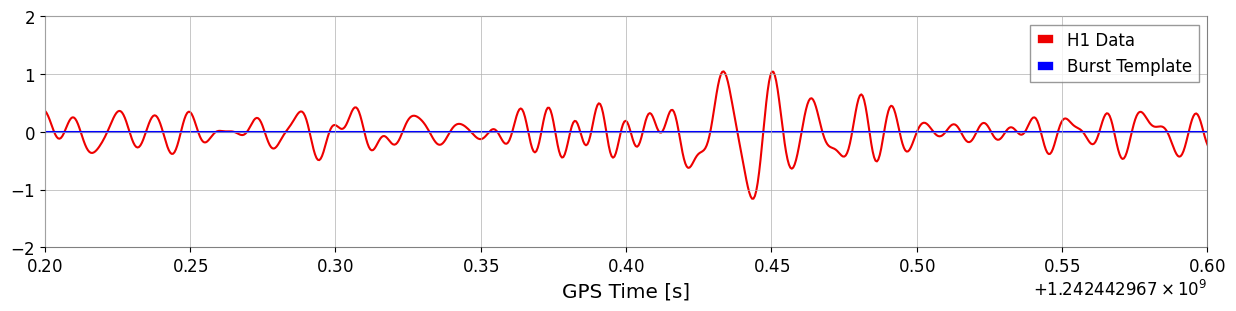

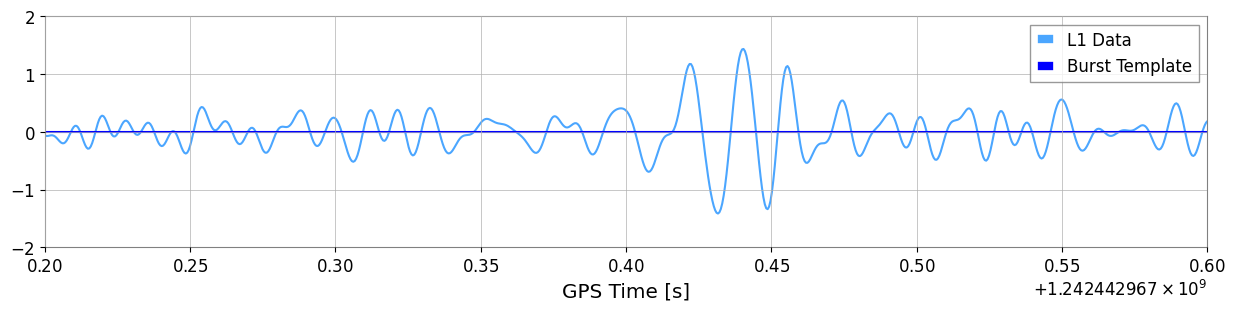

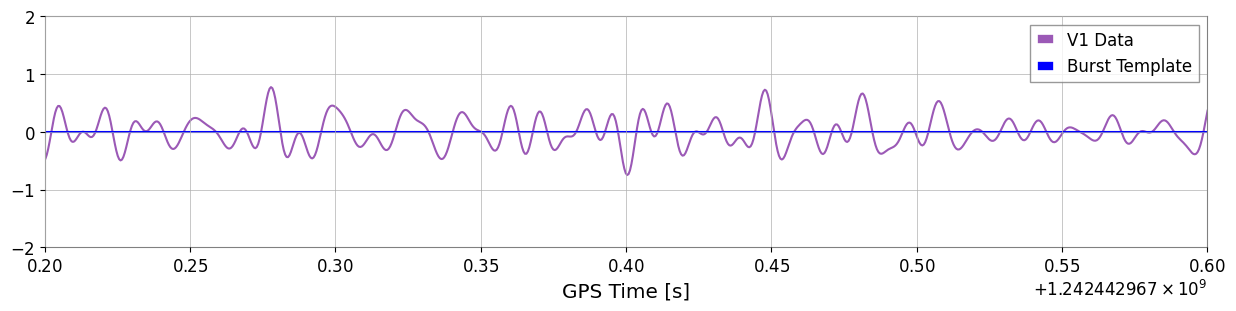

In [66]:
for ifo, colour in zip(ifos, colours):
    white_template_b = template0_b[ifo].whiten(asd = np.sqrt(psd[ifo]), highpass = 20.)

    plt.figure(figsize=[15, 3])
    plt.plot(white_data[ifo].times, white_data[ifo], color = colour, label = f"{ifo} Data")
    plt.plot(white_template_b.times, white_template_b, color = 'b', label = "Burst Template")
    plt.xlabel('GPS Time [s]')

    plt.xlim(gps-0.2, gps+0.2)
    plt.ylim(-2, 2)
    plt.legend();
print(loglikelihood_burst(param0))

There is an issue with the time shift of the gauspulse. Either that or it is struglling to make gausspulse at a time this high

In [67]:
# rrr

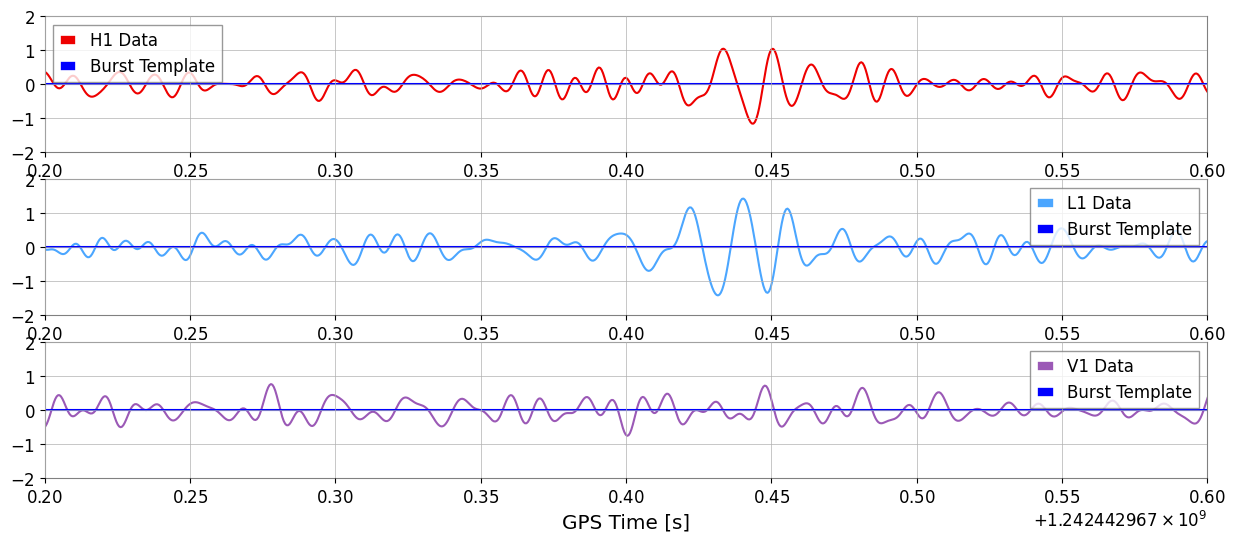

Steps	log(likelihood)
1	0.000


In [68]:
fig, axs = plt.subplots(3, 1, figsize=[15, 6])
Neval = 1

lines = {}
for ax, ifo, colour in zip(axs, ifos, colours):
    hite_template = template0_b[ifo].whiten(asd = np.sqrt(psd[ifo]), highpass = 20.)

    ax.plot(white_data[ifo].times, white_data[ifo], color = colour, label = f"{ifo} Data")
    lines[ifo], = ax.plot(white_template_b.times, white_template_b, color = 'b', label = "Burst Template")

    ax.set_xlabel('GPS Time [s]')
    ax.set_xlim(gps-0.2, gps+0.2)
    ax.set_ylim(-2, 2)
    ax.legend()

def callback(param_i):
    global Neval
    global line
    global fig

    template_b = gen_template_burst(param_i)
    for ifo in ifos:
        white_template_b = template_b[ifo].whiten(asd = np.sqrt(psd[ifo]), highpass = 20.)
        lines[ifo].set_ydata(white_template_b)

    clear_output(wait = True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, loglikelihood_burst(param_i)))

    Neval += 1

res_b = minimize(lambda param: -loglikelihood_burst(param), param0, callback = callback, method = 'powell')
plt.close()

In [69]:
res_b.x

array([6.2e+01, 3.0e-01, 4.0e-22])

TypeError: logposterior() missing 3 required positional arguments: 'data', 'sigma', and 'x'

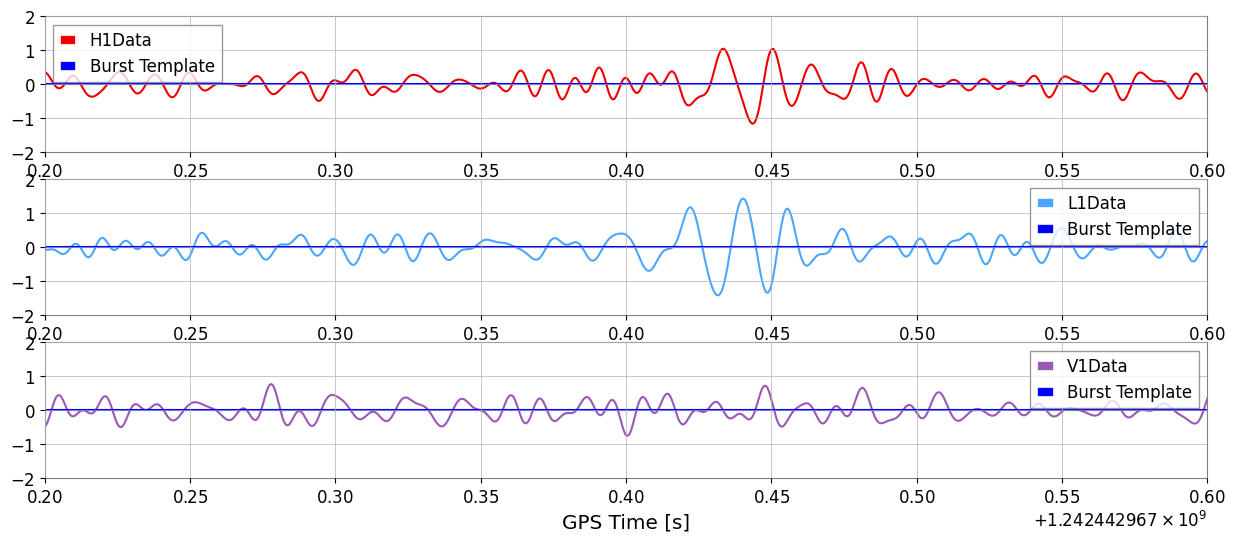

In [70]:
fig, axs = plt.subplots(3, 1, figsize=[15, 6])
Neval = 1

lines = {}
for ax, ifo, colour in zip(axs, ifos, colours):
    hite_template = template0_b[ifo].whiten(asd = np.sqrt(psd[ifo]), highpass = 30.)

    ax.plot(white_data[ifo].times, white_data[ifo], color = colour, label = f"{ifo}Data")
    lines[ifo], = ax.plot(white_template_b.times, white_template_b, color = 'b', label = "Burst Template")

    ax.set_xlabel('GPS Time [s]')
    ax.set_xlim(gps-0.2, gps+0.2)
    ax.set_ylim(-2, 2)
    ax.legend()

def callback(param_i):
    global Neval
    global line
    global fig

    template_b = gen_template_burst(param_i)
    for ifo in ifos:
        white_template_b = template_b[ifo].whiten(asd = np.sqrt(psd[ifo]), highpass = 30.)
        lines[ifo].set_ydata(white_template_b)

    clear_output(wait = True)
    display(fig)
    print("Steps\tlog(posterior)")
    print('{}\t{:.3f}'.format(Neval, logposterior(param_i)))

    Neval += 1

res_b = minimize(lambda param: -logposterior(param), param0, callback = callback, method = 'powell')
plt.close()

Since the Burst model code was not able to run by submission, I am unable to compare my results but I can describe how I would. Now the Burst model does not actually estimate any parameters. Only the band width, frequency and amplitude. So a direct comparison of the values is out of the question. But one could compare the logposterior values from the minimsation as a way of comparing the two sets of results.

CBC Model

The best guess for m1 is 155.044

The best guess for m2 is 134.475

The best guess for the distance is 3285.918

The best guess for the inspiral start time is 1242442967.432

The best guess for the phase is 0.010

The best guess for the right ascension is 3.184

The best guess for the declination is -0.588

The best guess for the inclination is 0.516

The best guess for the polarisation is 0.004

## Conclusions (15 points)
Minimum 300 words.
- Discuss your results in the context of the literature.
- Mention how your work compares with published results.
- Discuss some of the interpretation possibles of GW190521, including relevant citations from the literature, and summarising them.

An analysis of the data from the event GW190521 was conducted and results were produced for the CBC model. The primary and secondary masses found by the CBC minimisation were estimated to be 155.044M$_\odot$ and 134.475M$_\odot$, respectively. The redshifted primary and secondary masses were found by the discovery paper to be 154.7M$_\odot$ and 120.12M$_\odot$$^{[1]}$, respectively. The primary mass is consistent with the values from the literature. However, the secondary mass is not as consistent with it being aprroximately 14M$_\odot$ off from the value in the literature. We have not included spin our CBC model and that may well have been the cause for this discrepancy in the secondary mass. Perhaps including spin in the CBC model may allow for results that are more consistent with the literature.

The distance found from the CBC minimisation was 3000Mpc, this is not consistent with the value from the discovery paper which was 5300Mpc$^{[1]}$. The reason for this is likely due to the degeneracy with the inclination. The discovery paper had a lower inclination of approximately 0.3$^{[1]}$. The CBC minimisation produces an inclination of 0.516. This increase in inclination causes a decrease in the distance due to the degeneracy. This is likely the reason why I estimate a smaller distance than the one in the discovery paper. One could put limits on the prior to stop the inclination from increasing above 0.3 but this would not be scientifically viable, so it should not be done.

Based on the resulting masses from m1 and m2 as well as the consistency with the literature it is likely safe to say that the objects observed in this GW detection are indeed BH and they do form an IMBH after
coalescence.

Additionally, the phase from the CBC minimisation was found to be 0.010 radians.

the polarisation from the CBC minimisation was found to be 0.004 radians.

the RA and Dec from the CBC minimisation was found to be 3.184 radians and -0.588 radians, respectively. This is consistent with the results from the EM counterpart paper$^{[2]}$ (3.36 and -0.6078). This *suggests that the two AGNs observed may well be the EM counterpart to this GW detection.

[1] - R. Abbott, T. D. Abbott, S. Abraham, et al., “Gw190521: A binary black
hole merger with a total mass of 150 M$_\odot$,” Phys. Rev. Lett., vol. 125,
p. 101 102, 10 Sep. 2020. doi: 10.1103/PhysRevLett.125.101102. [On-
line]. Available: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.125.101102. 125.101102.

[2] - M. J. Graham, K. E. S. Ford, B. McKernan, et al., “Candidate electro-
magnetic counterpart to the binary black hole merger gravitational-wave
event s190521g,” Phys. Rev. Lett., vol. 124, p. 251 102, 25 Jun. 2020. doi:
10.1103/PhysRevLett.124.251102. [Online]. Available: https://link.aps.org/doi/10.1103/PhysRevLett.124.251102.